<a href="https://colab.research.google.com/github/krishnannarayanaswamy/GenAI-Relevance-LLM-demo/blob/main/ZeroShotClassification_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install openai
!pip3 install pandas
!pip3 install transformers
!pip3 install sentence_transformers
!pip3 install plotly
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install torch
!pip3 install torchvision
!pip3 install scipy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.4 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=7cac12e4d82c25193d6dec8566dd523b001643f0b28b21f616fc117276a89da4
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [2]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [3]:
sequence_to_classify = "one day I will see the world"
candidate_labels = ['travel', 'cooking', 'dancing']

classifier(sequence_to_classify, candidate_labels)

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'dancing', 'cooking'],
 'scores': [0.9938650727272034, 0.0032738037407398224, 0.0028610494919121265]}

In [4]:
candidate_labels = ['travel', 'cooking', 'dancing', 'exploration']
classifier(sequence_to_classify, candidate_labels, multi_label=True)

{'sequence': 'one day I will see the world',
 'labels': ['travel', 'exploration', 'dancing', 'cooking'],
 'scores': [0.994511067867279,
  0.9383884072303772,
  0.0057061826810240746,
  0.0018193012801930308]}

In [13]:
import pandas as pd
df = pd.read_csv('fine_food_reviews_1k.csv')
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
     df.Summary.str.strip() + "." + df.Text.str.strip()
)
# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})

df.head(2)

,Time,ProductId,UserId,Score,Summary,Text,combined,sentiment
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,where does one start...and stop... with a tre...,positive
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Arrived in pieces.Not pleased at all. When I o...,negative


In [27]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

candidate_labels = ['positive', 'negative']
hypothesis_template = "The sentiment of this review is {}."
dfsubset = df.head(25)

sequences = dfsubset['combined'].to_list()

# Prediction results
hf_prediction = classifier(sequences, candidate_labels, hypothesis_template=hypothesis_template)

# Save the output as a dataframe
hf_prediction = pd.DataFrame(hf_prediction)

hf_prediction['hf_prediction'] = hf_prediction['labels'].apply(lambda x: x[0])

hf_prediction['hf_predicted_score'] = hf_prediction['scores'].apply(lambda x: x[0])

#hf_prediction['hf_prediction'] = hf_prediction['hf_prediction'].map({'positive': 1, 'negative': 0})

hf_prediction['true_label'] = le.fit_transform(dfsubset['sentiment'].astype(str))

hf_prediction['true_label'] =  hf_prediction['true_label'].apply(lambda x: 'positive' if x>0 else 'negative')

# Take a look at the data
hf_prediction.head()

#dfsubset["output"] = dfsubset.combined.apply(lambda x: classifier(x, candidate_labels, hypothesis_template=hypothesis_template))
#dfnew = dfsubset["output"].apply(lambda x: pd.DataFrame(x))
#dfnew.head(5)

,sequence,labels,scores,hf_prediction,hf_predicted_score,true_label
0,where does one start...and stop... with a tre...,"[positive, negative]","[0.9739232659339905, 0.026076769456267357]",positive,0.973923,positive
1,Arrived in pieces.Not pleased at all. When I o...,"[negative, positive]","[0.9919748902320862, 0.008025145158171654]",negative,0.991975,negative
2,"It isn't blanc mange, but isn't bad . . ..I'm ...","[negative, positive]","[0.7164624929428101, 0.28353747725486755]",negative,0.716462,positive
3,Happy with the product.My dog was suffering wi...,"[positive, negative]","[0.9979624152183533, 0.002037634141743183]",positive,0.997962,positive
4,Good Sauce.This is a good all purpose sauce. ...,"[positive, negative]","[0.9959288239479065, 0.0040711937472224236]",positive,0.995929,positive


In [28]:
    from sklearn.metrics import classification_report
    from sklearn.metrics import PrecisionRecallDisplay


    report = classification_report(hf_prediction.true_label, hf_prediction.hf_prediction)
    print(report)


   # display = PrecisionRecallDisplay.from_predictions(hf_prediction.true_label, hf_prediction.hf_prediction, pos_label='positive')
   # _ = display.ax_.set_title("2-class Precision-Recall curve")

              precision    recall  f1-score   support

    negative       0.83      0.71      0.77         7
    positive       0.89      0.94      0.92        18

    accuracy                           0.88        25
   macro avg       0.86      0.83      0.84        25
weighted avg       0.88      0.88      0.88        25



In [ ]:
# imports
import openai
import pandas as pd
import numpy as np
from ast import literal_eval

from sklearn.metrics import classification_report



openai.api_key = ''

# parameters
EMBEDDING_MODEL = "text-embedding-ada-002"

In [ ]:
# load data
# = "data/fine_food_reviews_with_embeddings_1k.csv"

df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv')
df["embedding"] = df.embedding.apply(literal_eval).apply(np.array)

# convert 5-star rating to binary sentiment
df = df[df.Score != 3]
df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})
df.head()

<ipython-input-6-11f8908dcbe1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df.Score.replace({1: "negative", 2: "negative", 4: "positive", 5: "positive"})


,Unnamed: 0,ProductId,UserId,Score,Summary,Text,combined,n_tokens,embedding,sentiment
0,0,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title: where does one start...and stop... wit...,52,"[0.007018072064965963, -0.02731654793024063, 0...",positive
1,297,B003VXHGPK,A21VWSCGW7UUAR,4,"Good, but not Wolfgang Puck good","Honestly, I have to admit that I expected a li...","Title: Good, but not Wolfgang Puck good; Conte...",178,"[-0.003140551969408989, -0.009995664469897747,...",positive
2,296,B008JKTTUA,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,...",negative
3,295,B000LKTTTW,A14MQ40CCU8B13,5,Best tomato soup,I have a hard time finding packaged food of an...,Title: Best tomato soup; Content: I have a har...,111,"[-0.0013932279543951154, -0.011112828738987446...",positive
4,294,B001D09KAM,A34XBAIFT02B60,1,Should advertise coconut as an ingredient more...,"First, these should be called Mac - Coconut ba...",Title: Should advertise coconut as an ingredie...,78,"[-0.01757248118519783, -8.266511576948687e-05,...",negative


              precision    recall  f1-score   support

    negative       0.62      0.88      0.73       136
    positive       0.98      0.90      0.94       789

    accuracy                           0.90       925
   macro avg       0.80      0.89      0.83       925
weighted avg       0.92      0.90      0.91       925



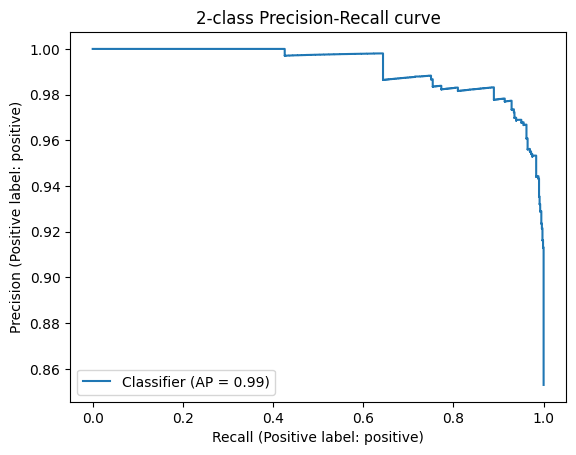

In [ ]:
from openai.embeddings_utils import cosine_similarity, get_embedding
from sklearn.metrics import PrecisionRecallDisplay

def evaluate_embeddings_approach(
    labels = ['negative', 'positive'],
    model = EMBEDDING_MODEL,
):
    label_embeddings = [get_embedding(label, engine=model) for label in labels]

    def label_score(review_embedding, label_embeddings):
        return cosine_similarity(review_embedding, label_embeddings[1]) - cosine_similarity(review_embedding, label_embeddings[0])

    probas = df["embedding"].apply(lambda x: label_score(x, label_embeddings))
    preds = probas.apply(lambda x: 'positive' if x>0 else 'negative')

    report = classification_report(df.sentiment, preds)
    print(report)

    display = PrecisionRecallDisplay.from_predictions(df.sentiment, probas, pos_label='positive')
    _ = display.ax_.set_title("2-class Precision-Recall curve")

evaluate_embeddings_approach(labels=['negative', 'positive'], model=EMBEDDING_MODEL)

              precision    recall  f1-score   support

    negative       0.98      0.73      0.84       136
    positive       0.96      1.00      0.98       789

    accuracy                           0.96       925
   macro avg       0.97      0.86      0.91       925
weighted avg       0.96      0.96      0.96       925



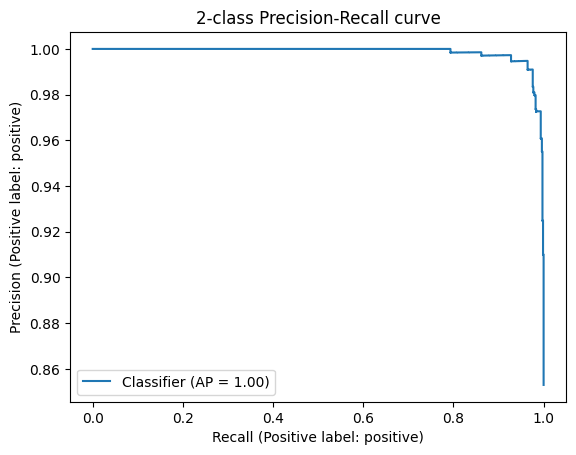

In [ ]:
evaluate_embeddings_approach(labels=['An Amazon review with a negative sentiment.', 'An Amazon review with a positive sentiment.'])